# Exploring data on gun violence

The goal of this project is to use pandas and GeoPandas to explore a dataset on gun violence, ultimately resulting in a clean dataset that can be pulled into a webmap.

Datasource: The CSV file obtained for this project was retrieved from [Gun Violence Data](https://github.com/jamesqo/gun-violence-data), an accessible database compiled through webscraping of [Gun Violence Archive](https://www.gunviolencearchive.org/). Gun Violence Archive is a non-profit research organization that documents gun incidents and crimes.

## Table of Contents
1. [Import packages and data](#import-packages-and-data)
2. [Preliminary data exploration](#preliminary-data-exploration)
3. [Filter and clean data](#filter-and-clean-data)
4. [Plot graphs to explore trends or patterns](#plot-graphs)
5. [Start mapping the data](#start-mapping)
    1. [Aggregate incidents by congressional district](#aggregate-incidents)
    2. [Join legislator contact list to congressional district GeoDataFrame](#join-contact-list)
6. [Export data](#export-data)

## Import packages and data <a name="import-packages-and-data">

In [558]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping
import shapely.speedups
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

#change default figure size
plt.rcParams['figure.figsize'] = (15, 12)

In [559]:
#read data into notebook
df_in = pd.read_excel('data/gun_violence.xlsx')

In [560]:
#make copy of data to explore
#can resort back to original data if need be without reading back in
df = df_in.copy()

## Preliminary data exploration <a name="preliminary-data-exploration">

In [561]:
#set options so that all columns and their contents are displayed
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 999)

#how many records are there?
print(df.shape)

#inspect a small sample to get an idea of the columns and their contents
df.sample(5)

(239677, 29)


,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
156588,702070,2016-11-15,Florida,Fort Pierce,1400 block of Havana Avenue,1,0,http://www.gunviolencearchive.org/incident/702070,http://www.palmbeachpost.com/news/crime--law/police-man-shot-fort-pierce-life-support/2XjA4JPJu8M7fJbxZhcpqL/,False,18.0,0::Unknown,0::Unknown,"Shot - Dead (murder, accidental, suicide)||Home Invasion||Home Invasion - Resident killed",27.4388,NaN,-80.3381,1.0,"targeted hi, vic likely NOT target, other person present",0::26,0::Adult 18+||1::Adult 18+||2::Adult 18+,0::Male||1::Male||2::Male,0::Vladimir Juels,NaN,0::Killed||1::Unharmed||2::Unharmed,0::Victim||1::Subject-Suspect||2::Subject-Suspect,http://www.tcpalm.com/story/news/crime/st-lucie-county/2016/11/16/fort-pierce-police-identify-shooting-victim/93953336/||http://www.palmbeachpost.com/news/crime--law/police-man-shot-fort-pierce-life-support/2XjA4JPJu8M7fJbxZhcpqL/,84.0,32.0
148272,664147,2016-09-26,Texas,Longview,600 block of Pine Tree Road,0,0,http://www.gunviolencearchive.org/incident/664147,https://www.news-journal.com/news/2016/sep/26/police-longview-man-steals-car-during-traffic-stop/,False,1.0,0::Stolen||1::Unknown,0::Unknown||1::Unknown,Non-Shooting Incident||Drug involvement||Possession (gun(s) found during commission of other crimes)||Possession of gun by felon or prohibited person||Gun(s) stolen from owner,32.5126,NaN,-94.7972,2.0,Drug involvement.,0::37,0::Adult 18+,0::Male,0::Draper Demetric Kennedy,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,https://www.news-journal.com/news/2016/sep/26/police-longview-man-steals-car-during-traffic-stop/,7.0,1.0
182348,821958,2017-04-16,Wisconsin,Milwaukee,N 50th St and W Chambers St,0,0,http://www.gunviolencearchive.org/incident/821958,http://itmdapps.ci.mil.wi.us/MPDCallData/currentCADCalls/callsService.faces,False,4.0,0::Unknown,0::Unknown,Shots Fired - No Injuries,43.0735,NaN,-87.9761,1.0,shots fired unclear if inj approx 10 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://itmdapps.ci.mil.wi.us/MPDCallData/currentCADCalls/callsService.faces,17.0,6.0
188138,847330,2017-05-19,North Carolina,High Point,1000 block of Oberline Dr,0,2,http://www.gunviolencearchive.org/incident/847330,http://www.wfmynews2.com/news/crime/2-injured-after-being-shot-inside-car-in-high-point-police/441254689,False,12.0,0::Unknown,0::Unknown,Shot - Wounded/Injured,35.9754,NaN,-79.9659,1.0,NaN,NaN,0::Adult 18+||1::Adult 18+,0::Male||1::Female,NaN,NaN,0::Injured||1::Injured,0::Victim||1::Victim,http://www.wxii12.com/article/two-people-taken-to-hospital-after-high-point-shooting/9884124||http://www.wfmynews2.com/news/crime/2-injured-after-being-shot-inside-car-in-high-point-police/441254689,60.0,28.0
129769,574482,2016-06-07,Pennsylvania,Philadelphia,I-95 North,0,0,http://www.gunviolencearchive.org/incident/574482,http://6abc.com/news/suspect-in-i-95-shooting-i-didnt-do-it-on-purpose/1378505/,False,1.0,0::Unknown,0::Handgun,"Shots Fired - No Injuries||Drive-by (car to street, car to car)||Road rage||Possession of gun by felon or prohibited person",39.9478,NaN,-75.1420,1.0,NaN,0::38||1::33,0::Adult 18+||1::Adult 18+,0::Male||1::Male,1::Anthony Gilbert,NaN,0::Unharmed||1::Arrested,0::Victim||1::Subject-Suspect,http://philadelphia.cbslocal.com/2016/06/07/suspect-sought-after-road-rage-shooting-on-i-95-in-philadelphia/||http://philadelphia.cbslocal.com/2016/06/09/1-in-custody-in-connection-with-road-rage-shooting-earlier-this-week/||http://6abc.com/news/suspect-in-i-95-shooting-i-didnt-do-it-on-purpose/1378505/,NaN,NaN


Already I can see that there is a column for the number killed (n_killed) and number injured (n_injured). There are latitude/longitude coordinates I could use to map each incident, and there is also a column for congressional district which gives me an idea to explore mapping these incidents by congressional district. Each incident also has a date, so I could explore trends or patterns over time. There are also some other descriptive columns such as participant names, ages, and relationships, type of gun used, and incident characteristics.

In [562]:
#lets explore some more of these descriptive columns
#get a list of column names
df.columns.unique()

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district'],
      dtype='object')

In [563]:
#look at sample of values in the participant age column
df['participant_age'].sample(15)

171589    0::30              
109320    0::29              
71949     0::31              
84203     0::24||1::19||2::19
56692     0::31              
196029    NaN                
64491     NaN                
143714    NaN                
39750     0::25              
196991    0::22              
176801    0::36||1::43       
95020     1::29              
137021    0::34||1::39||2::23
70396     0::25              
144873    0::31              
Name: participant_age, dtype: object

In [564]:
#look at sample of values in the participant gender column
df['participant_gender'].sample(15)

73932     NaN                                        
23949     0::Female                                  
119033    0::Male                                    
162943    0::Male||1::Male||2::Male||3::Male||4::Male
128250    0::Male                                    
69761     NaN                                        
207650    0::Male||1::Male                           
27430     NaN                                        
141996    0::Male||1::Male||2::Male                  
5778      0::Male||1::Male||2::Male||3::Male         
109649    0::Male||1::Male                           
20784     1::Male                                    
223476    0::Male                                    
65246     0::Male                                    
87534     0::Male                                    
Name: participant_gender, dtype: object

In [565]:
#look at sample of values in the participant age column
df['participant_type'].sample(15)

51666     0::Subject-Suspect                                            
105506    0::Victim||1::Subject-Suspect                                 
112903    0::Victim||1::Victim||2::Subject-Suspect                      
219061    0::Victim||1::Subject-Suspect                                 
12475     0::Victim                                                     
159436    0::Victim||1::Victim||2::Victim||3::Victim||4::Subject-Suspect
122461    0::Subject-Suspect                                            
57197     0::Victim||1::Subject-Suspect                                 
27706     0::Victim||1::Victim                                          
43619     0::Victim                                                     
53759     NaN                                                           
31470     0::Victim                                                     
94022     0::Subject-Suspect||1::Subject-Suspect                        
1962      0::Victim                                

In [566]:
#look at sample of values in the incident characteristics column
df['incident_characteristics'].sample(15)

222706    Shot - Wounded/Injured||Shot - Dead (murder, accidental, suicide)                                                                                                                                                                         
116356    Shot - Wounded/Injured                                                                                                                                                                                                                    
139810    Shot - Wounded/Injured||Accidental Shooting||Accidental Shooting - Injury||Accidental/Negligent Discharge||Self-Inflicted (not suicide or suicide attempt - NO PERP)||Cleaning gun||Concealed Carry License - Victim                      
66554     Non-Shooting Incident||Officer Involved Incident||Officer Involved Incident - Weapon involved but no shots fired||Drug involvement||ATF/LE Confiscation/Raid/Arrest||Possession (gun(s) found during commission of other crimes)          
101630    Non-Shooti

## Filter and clean data <a name="filter-and-clean-data">

After inspecting some of these columns further, it looks like filtering or categorizing based on these descriptive columns is going to be difficult. The unique values vary too much because each incident may contain any number of combinations of descriptive characteristics. But since there are columns for the number killed and number injured, I am going to filter the data to only include incidents with death or injury.

In [567]:
#get subset of data
#where n_killed or n_injured is greater than 0
df_filter = df[(df['n_killed'] > 0) | (df['n_injured'] > 0)]
df_filter

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/01/17/Man-arrested-in-New-Year-s-Eve-shooting-in-McKeesport/stories/201301170275,False,14.0,NaN,NaN,"Shot - Wounded/Injured||Mass Shooting (4+ victims injured or killed excluding the subject/suspect/perpetrator, one location)||Possession (gun(s) found during commission of other crimes)||Possession of gun by felon or prohibited person",40.3467,NaN,-79.8559,NaN,Julian Sims under investigation: Four Shot and Injured,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::Adult 18+||4::Adult 18+,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injured||4::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4::Subject-Suspect,http://pittsburgh.cbslocal.com/2013/01/01/4-people-shot-in-mckeesport/||http://www.wtae.com/news/local/allegheny/U-S-Marshals-task-force-arrests-New-Year-s-party-shooting-suspect/17977588||http://www.post-gazette.com/local/south/2013/01/17/Man-arrested-in-New-Year-s-Eve-shooting-in-McKeesport/stories/201301170275,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/20130105/NEWS/130109127,False,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, accidental, suicide)||Mass Shooting (4+ victims injured or killed excluding the subject/suspect/perpetrator, one location)||Gang involvement",33.9090,NaN,-118.3330,NaN,Four Shot; One Killed; Unidentified shooter in getaway car,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::Adult 18+,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4::Subject-Suspect,http://losangeles.cbslocal.com/2013/01/01/man-killed-3-wounded-at-nye-party-in-hawthorne/||http://latimesblogs.latimes.com/lanow/2013/01/hawthorne-new-year-party-three-killed.html||https://usgunviolence.wordpress.com/2013/01/01/killed-man-hawthorne-ca/||http://www.dailybulletin.com/article/zz/20130105/NEWS/130109127,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/2-men-indicted-in-new-years-day-lorain-murder/,False,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, accidental, suicide)||Shots Fired - No Injuries||Bar/club incident - in or around establishment",41.4455,Cotton Club,-82.1377,2.0,NaN,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::Adult 18+||4::Adult 18+,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Seagers||3::Ladd Tate Sr||4::Tallis Moore,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, Arrested||2::Killed||3::Injured||4::Injured",0::Subject-Suspect||1::Subject-Suspect||2::Victim||3::Victim||4::Victim,http://www.morningjournal.com/general-news/20130222/lorain-man-pleads-innocent-to-new-years-murder||http://chronicle.northcoastnow.com/2013/02/14/2-men-indicted-in-new-years-day-lorain-murder/,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-shootout-killer-was-frenetic-talented-neighbor-says,False,6.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Officer Involved Incident||Officer Involved Shooting - sub

In [568]:
#since I am focusing on incidents with death or injury
#lets delete some of those columns that we won't need
df_filter = df_filter.drop(['incident_url_fields_missing', 'gun_stolen', 'gun_type', 'participant_age', 'participant_age_group',
                    'participant_gender', 'participant_name', 'participant_relationship', 'participant_status',
                    'participant_type', 'n_guns_involved'], axis=1)

In [569]:
df_filter

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,congressional_district,incident_characteristics,latitude,location_description,longitude,notes,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/01/17/Man-arrested-in-New-Year-s-Eve-shooting-in-McKeesport/stories/201301170275,14.0,"Shot - Wounded/Injured||Mass Shooting (4+ victims injured or killed excluding the subject/suspect/perpetrator, one location)||Possession (gun(s) found during commission of other crimes)||Possession of gun by felon or prohibited person",40.3467,NaN,-79.8559,Julian Sims under investigation: Four Shot and Injured,http://pittsburgh.cbslocal.com/2013/01/01/4-people-shot-in-mckeesport/||http://www.wtae.com/news/local/allegheny/U-S-Marshals-task-force-arrests-New-Year-s-party-shooting-suspect/17977588||http://www.post-gazette.com/local/south/2013/01/17/Man-arrested-in-New-Year-s-Eve-shooting-in-McKeesport/stories/201301170275,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/20130105/NEWS/130109127,43.0,"Shot - Wounded/Injured||Shot - Dead (murder, accidental, suicide)||Mass Shooting (4+ victims injured or killed excluding the subject/suspect/perpetrator, one location)||Gang involvement",33.9090,NaN,-118.3330,Four Shot; One Killed; Unidentified shooter in getaway car,http://losangeles.cbslocal.com/2013/01/01/man-killed-3-wounded-at-nye-party-in-hawthorne/||http://latimesblogs.latimes.com/lanow/2013/01/hawthorne-new-year-party-three-killed.html||https://usgunviolence.wordpress.com/2013/01/01/killed-man-hawthorne-ca/||http://www.dailybulletin.com/article/zz/20130105/NEWS/130109127,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/2-men-indicted-in-new-years-day-lorain-murder/,9.0,"Shot - Wounded/Injured||Shot - Dead (murder, accidental, suicide)||Shots Fired - No Injuries||Bar/club incident - in or around establishment",41.4455,Cotton Club,-82.1377,NaN,http://www.morningjournal.com/general-news/20130222/lorain-man-pleads-innocent-to-new-years-murder||http://chronicle.northcoastnow.com/2013/02/14/2-men-indicted-in-new-years-day-lorain-murder/,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-shootout-killer-was-frenetic-talented-neighbor-says,6.0,"Shot - Dead (murder, accidental, suicide)||Officer Involved Incident||Officer Involved Shooting - subject/suspect/perpetrator killed||Drug involvement||Kidnapping/abductions/hostage||Under the influence of alcohol or drugs (only applies to the subject/suspect/perpetrator )",39.6518,NaN,-104.8020,NaN,http://denver.cbslocal.com/2013/01/06/officer-told-neighbor-standoff-gunman-was-on-meth-binge/||http://www.westword.com/news/sonny-archuleta-triple-murder-in-aurora-guns-purchased-legally-55-57-5900504||http://www.denverpost.com/ci_22322380/aurora-shooter-was-frenetic-talented-neighbor-says||http://www.dailymail.co.uk/news/article-2258008/Sonny-Archuleta-Gunman-left-dead-latest-Aurora-shooting-lost-brother-gun-violence.html||http://www.dailydemocrat.com/20130106/aurora-shootout-killer-was-frenetic-talented-neighbor-says,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d4c723e8-5a0f-11e2-a1fa-0019bb30f31a.html,6.0,"Shot - Wounded/Injured||Shot - Dead (murder, accidental, suicide)||Suicide^||Murder/Suicide||Attempted Murder/Suicide (one variable unsuccessful)||Domestic Violence",36.1140,NaN,-79.9569,"Two firearms rec

In [570]:
#each incident has a date
#I want to create a year and a month column
df_filter['year'] = df_filter['date'].dt.year
df_filter['month'] = df_filter['date'].dt.month
df_filter

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,congressional_district,incident_characteristics,latitude,location_description,longitude,notes,sources,state_house_district,state_senate_district,year,month
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/01/17/Man-arrested-in-New-Year-s-Eve-shooting-in-McKeesport/stories/201301170275,14.0,"Shot - Wounded/Injured||Mass Shooting (4+ victims injured or killed excluding the subject/suspect/perpetrator, one location)||Possession (gun(s) found during commission of other crimes)||Possession of gun by felon or prohibited person",40.3467,NaN,-79.8559,Julian Sims under investigation: Four Shot and Injured,http://pittsburgh.cbslocal.com/2013/01/01/4-people-shot-in-mckeesport/||http://www.wtae.com/news/local/allegheny/U-S-Marshals-task-force-arrests-New-Year-s-party-shooting-suspect/17977588||http://www.post-gazette.com/local/south/2013/01/17/Man-arrested-in-New-Year-s-Eve-shooting-in-McKeesport/stories/201301170275,NaN,NaN,2013,1
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/20130105/NEWS/130109127,43.0,"Shot - Wounded/Injured||Shot - Dead (murder, accidental, suicide)||Mass Shooting (4+ victims injured or killed excluding the subject/suspect/perpetrator, one location)||Gang involvement",33.9090,NaN,-118.3330,Four Shot; One Killed; Unidentified shooter in getaway car,http://losangeles.cbslocal.com/2013/01/01/man-killed-3-wounded-at-nye-party-in-hawthorne/||http://latimesblogs.latimes.com/lanow/2013/01/hawthorne-new-year-party-three-killed.html||https://usgunviolence.wordpress.com/2013/01/01/killed-man-hawthorne-ca/||http://www.dailybulletin.com/article/zz/20130105/NEWS/130109127,62.0,35.0,2013,1
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/2-men-indicted-in-new-years-day-lorain-murder/,9.0,"Shot - Wounded/Injured||Shot - Dead (murder, accidental, suicide)||Shots Fired - No Injuries||Bar/club incident - in or around establishment",41.4455,Cotton Club,-82.1377,NaN,http://www.morningjournal.com/general-news/20130222/lorain-man-pleads-innocent-to-new-years-murder||http://chronicle.northcoastnow.com/2013/02/14/2-men-indicted-in-new-years-day-lorain-murder/,56.0,13.0,2013,1
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-shootout-killer-was-frenetic-talented-neighbor-says,6.0,"Shot - Dead (murder, accidental, suicide)||Officer Involved Incident||Officer Involved Shooting - subject/suspect/perpetrator killed||Drug involvement||Kidnapping/abductions/hostage||Under the influence of alcohol or drugs (only applies to the subject/suspect/perpetrator )",39.6518,NaN,-104.8020,NaN,http://denver.cbslocal.com/2013/01/06/officer-told-neighbor-standoff-gunman-was-on-meth-binge/||http://www.westword.com/news/sonny-archuleta-triple-murder-in-aurora-guns-purchased-legally-55-57-5900504||http://www.denverpost.com/ci_22322380/aurora-shooter-was-frenetic-talented-neighbor-says||http://www.dailymail.co.uk/news/article-2258008/Sonny-Archuleta-Gunman-left-dead-latest-Aurora-shooting-lost-brother-gun-violence.html||http://www.dailydemocrat.com/20130106/aurora-shootout-killer-was-frenetic-talented-neighbor-says,40.0,28.0,2013,1
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d4c723e8-5a0f-11e2-a1fa-0019bb30f31a.html,6.0,"Shot - Wounded/Injured||Shot - Dead (murder, accidental, suicide)||Suicide^||Murder/Suicide||Attempted Murder/Suicide (one variable unsuccessful)||Domestic Violence"

In [571]:
#create a pivot table to show total number of incidents by year and month
#to look for patterns or trends over time
pivot = pd.pivot_table(df_filter, index=['year'], values=['incident_id'], aggfunc='count', columns=['month'])
pivot

incident_id                                                          \
month           1       2       3       4       5       6       7       8   
year                                                                        
2013   15.0        12.0    19.0    17.0    27.0    31.0    34.0    28.0     
2014   2378.0      1611.0  2005.0  2175.0  2529.0  2503.0  2813.0  2636.0   
2015   2364.0      1832.0  2539.0  2583.0  3047.0  2827.0  3158.0  3032.0   
2016   2813.0      2290.0  2872.0  2752.0  3058.0  2910.0  3446.0  3538.0   
2017   3209.0      2679.0  2762.0  3127.0  3325.0  3225.0  3490.0  3270.0   
2018   2973.0      2248.0  2611.0 NaN     NaN     NaN     NaN     NaN       

                                       
month       9      10      11      12  
year                                   
2013   28.0    22.0    23.0    22.0    
2014   2459.0  2322.0  2282.0  2441.0  
2015   2917.0  2685.0  2639.0  2835.0  
2016   3118.0  3328.0  3226.0  3188.0  
2017   2977.0  3311.0  2938.0  2816.0  
2018  NaN     NaN     NaN     NaN

In [572]:
#after looking at the pivot table, it looks like 2013 and 2018 data is likely incomplete
#lets filter the data again to only include data from 2014-2017
df_filter_year = df_filter[(df_filter['year'] == 2014) | (df_filter['year'] == 2015) | (df_filter['year'] == 2016) | (df_filter['year'] == 2017)]

In [573]:
df_filter_year

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,congressional_district,incident_characteristics,latitude,location_description,longitude,notes,sources,state_house_district,state_senate_district,year,month
280,92383,2014-01-01,New York,Queens,113th Avenue,1,0,http://www.gunviolencearchive.org/incident/92383,http://www.timesledger.com/stories/2014/2/firstmurderupdate_web_2014_01_02_q.html,5.0,"Shot - Dead (murder, accidental, suicide)",40.7034,NaN,-73.7474,Perpetrator is being sought by police.,http://www.timesledger.com/stories/2014/2/firstmurderupdate_web_2014_01_02_q.html,33.0,14.0,2014,1
281,92142,2014-01-01,New York,Brooklyn,St. Johns Place,0,1,http://www.gunviolencearchive.org/incident/92142,http://www.nydailynews.com/new-york/nyc-crime/2-die-spate-nyc-holiday-violence-article-1.1563394,9.0,Shot - Wounded/Injured,40.6715,NaN,-73.9476,NaN,http://www.nydailynews.com/new-york/nyc-crime/2-die-spate-nyc-holiday-violence-article-1.1563394,43.0,20.0,2014,1
282,95261,2014-01-01,Missouri,Springfield,Beverly Hills and Temple,0,1,http://www.gunviolencearchive.org/incident/95261,http://www.ozarksfirst.com/story/deputies-6-year-old-child-shot-rushed-to-hospital/d/story/uzJ0SAO98UyiZK6kmlUNYw,7.0,Shot - Wounded/Injured,37.2646,NaN,-93.3007,NaN,http://www.ozarksfirst.com/story/deputies-6-year-old-child-shot-rushed-to-hospital/d/story/uzJ0SAO98UyiZK6kmlUNYw,131.0,30.0,2014,1
283,92272,2014-01-01,Georgia,Columbus,1327 23rd Street,0,1,http://www.gunviolencearchive.org/incident/92272,http://www.ledger-enquirer.com/2014/08/25/3264788/attempted-murder-suspect-in-new.html,2.0,Shot - Wounded/Injured,32.4848,NaN,-84.9727,NaN,http://www.ledger-enquirer.com/2014/01/02/2881510/police-investigating-shooting.html||http://www.ledger-enquirer.com/2014/08/25/3264788/attempted-murder-suspect-in-new.html,135.0,15.0,2014,1
284,92428,2014-01-01,New York,Syracuse,200 block of Ballard Avenue,0,1,http://www.gunviolencearchive.org/incident/92428,http://www.syracuse.com/news/index.ssf/2014/01/syracuse_police_investigate_shooting_on_south_side.html#incart_river_default,24.0,Shot - Wounded/Injured,43.0308,NaN,-76.1562,NaN,http://www.syracuse.com/news/index.ssf/2014/01/syracuse_police_investigate_shooting_on_south_side.html#incart_river_default,128.0,53.0,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225868,1020900,2017-12-31,Florida,Fort Pierce,601 N 25th St,0,1,http://www.gunviolencearchive.org/incident/1020900,http://www.tcpalm.com/story/news/crime/st-lucie-county/2018/01/04/police-teen-shot-neck-store-clerk-during-nye-armed-robbery-fort-pierce/1004941001/,18.0,"Shot - Wounded/Injured||Institution/Group/Business||Defensive Use||Defensive Use - Victim stops crime||Defensive Use - Crime occurs, victim shoots subject/suspect/perpetrator||Defensive Use - Stand Your Ground/Castle Doctrine established||Armed robbery with injury/death and/or evidence of DGU found",27.4549,Three O's Food Mart,-80.3500,NaN,http://www.tcpalm.com/story/news/crime/st-lucie-county/2018/01/04/police-teen-shot-neck-store-clerk-during-nye-armed-robbery-fort-pierce/1004941001/,84.0,25.0,2017,12
225869,1018012,2017-12-31,Alabama,Mobile,Rose Lane,0,1,http://www.gunviolencearchive.org/incident/1018012,http://www.wmcactionnews5.com/story/37168194/shooting-reported-in-west-mobile,1.0,Shot - Wounded/Injured,30.6577,NaN,-88.1559,NaN,http://www.wmcactionnews5.com/story/37168194/shooting-reported-in-west-mobile,103.0,35.0,2017,12
225872,1020965,2017-12-31,Florida,Saint Petersburg,170 Beach Dr NE,0,1,http://www.gunviolencearchive.org/incident/1020965,http://www.baynews9.com/content/news/baynews9/news/article.html/content/news/articles/bn9/2018/1/4/orlando_man_hurt_by_.html,13.0,Shot - Wounded/Injured||Institution/Group/Business,27.7730,Cassis American Brasserie,-82.6330,possible celebratory gunfire,http://www.baynews9.com/content/news/baynews9/news/article.html/content/news/articles/bn9/2018/1/4/orlando_man_hurt_by_.html,

In [574]:
#create pivot table again using data filtered by year
#showing total number of incidents by year and month
pivot_incidents = pd.pivot_table(df_filter_year, index=['year'], values=['incident_id'], aggfunc='count', columns=['month'])
pivot_incidents

incident_id                                                              \
month           1     2     3     4     5     6     7     8     9    10    11   
year                                                                            
2014   2378        1611  2005  2175  2529  2503  2813  2636  2459  2322  2282   
2015   2364        1832  2539  2583  3047  2827  3158  3032  2917  2685  2639   
2016   2813        2290  2872  2752  3058  2910  3446  3538  3118  3328  3226   
2017   3209        2679  2762  3127  3325  3225  3490  3270  2977  3311  2938   

             
month    12  
year         
2014   2441  
2015   2835  
2016   3188  
2017   2816

## Plot graphs to explore trends or patterns <a name="plot-graphs">

Before I start mapping the data, I want to see if I can pull out any patterns or trends in the data.

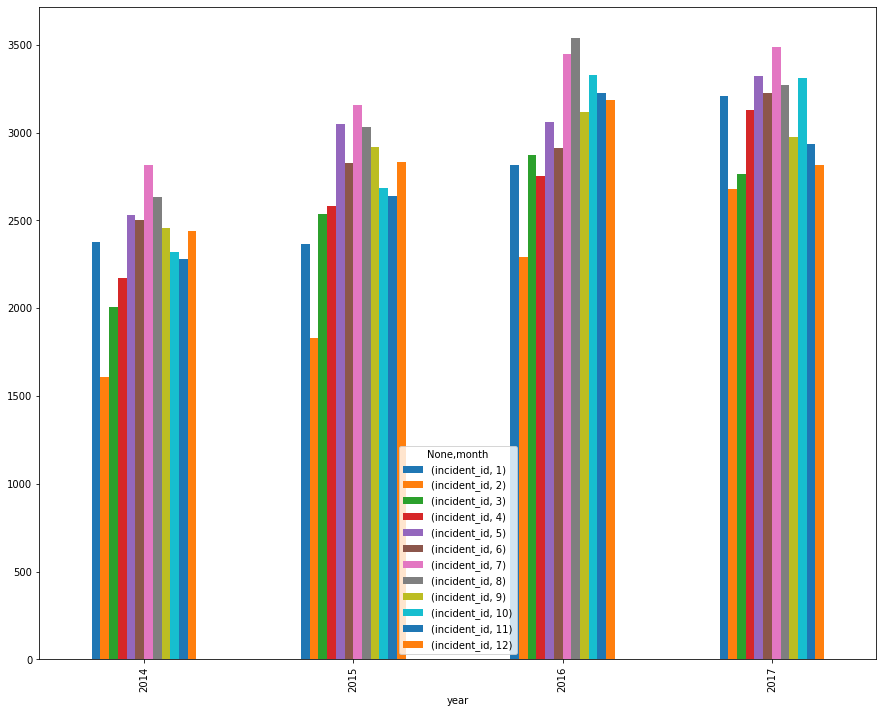

In [575]:
#plot the pivot table as bar graph to start exploring patterns
#it appears that there are consistently more incidents in January with a sharp drop in February
#it also appears that generally there are more incidents in warmer months than cooler months
pivot_incidents.plot(kind='bar');

In [576]:
#lets visualize the data in another way to explore any patterns
#create pivot tables for each year so we can visualize trends across each year
pivot_2014 = pd.pivot_table(df_filter_year[df_filter_year['year'] == 2014], index=['month'], values=['incident_id'], aggfunc='count')
pivot_2015 = pd.pivot_table(df_filter_year[df_filter_year['year'] == 2015], index=['month'], values=['incident_id'], aggfunc='count')
pivot_2016 = pd.pivot_table(df_filter_year[df_filter_year['year'] == 2016], index=['month'], values=['incident_id'], aggfunc='count')
pivot_2017 = pd.pivot_table(df_filter_year[df_filter_year['year'] == 2017], index=['month'], values=['incident_id'], aggfunc='count')

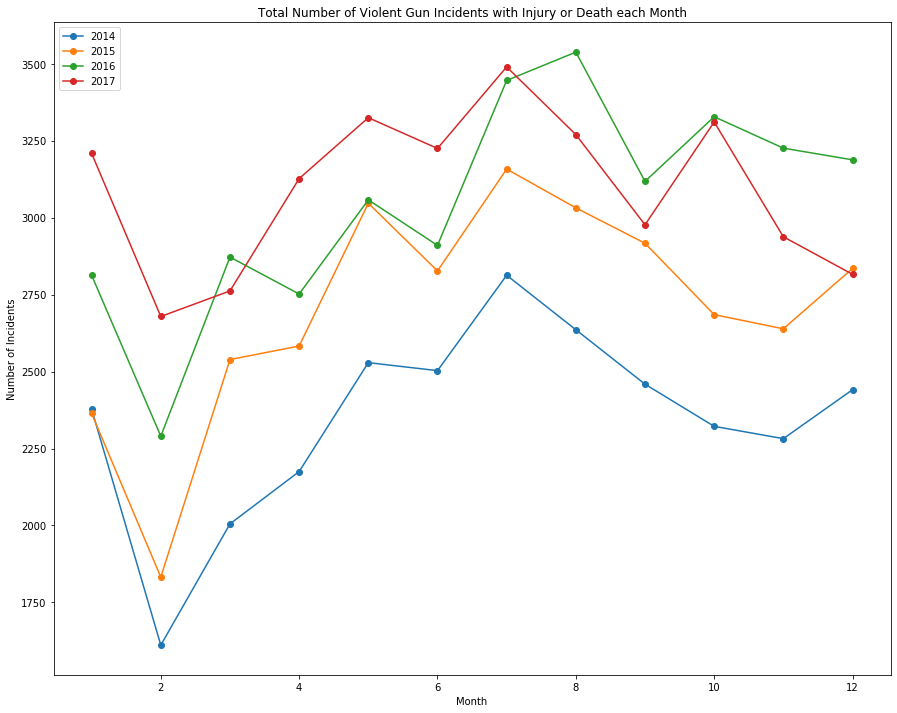

In [173]:
#plot line graphs with markers to visualize trends
#plot a series for each year to compare trends across years,
#showing total number of incidents with injury or death per month
ax1 = plt.plot(pivot_2014.index, pivot_2014.values, '-o')
ax2 = plt.plot(pivot_2015.index, pivot_2015.values, '-o')
ax3 = plt.plot(pivot_2016.index, pivot_2016.values, '-o')
ax4 = plt.plot(pivot_2017.index, pivot_2017.values, '-o')

plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.title('Total Number of Violent Gun Incidents with Injury or Death each Month')
plt.legend(('2014', '2015', '2016', '2017'), loc = 'upper left');

Each year tends to follow the same general pattern across time. It also looks like incidents tended to increase each year when you compare months from each year, except July of 2017, when incidents start to dip below the 2016 line.

In [577]:
#I want to look at a graph showing only one series, with the total number of incidents aggregated by month
#create new pivot table to show total number of incidents aggregated by month
#use this to create scatterplot to see if there is a trend across the year in general
pivot_by_month = pd.pivot_table(df_filter_year, index=['month'], values=['incident_id'], aggfunc='count')
pivot_by_month

,incident_id
month,
1,10764
2,8412
3,10178
4,10637
5,11959
6,11465
7,12907
8,12476
9,11471


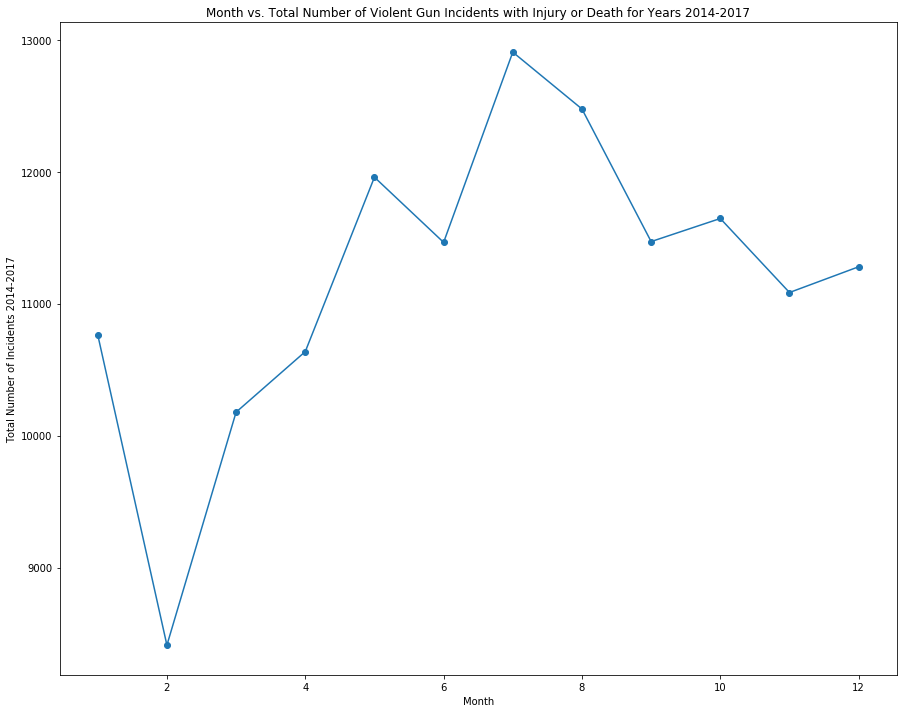

In [578]:
#plot line graph with markers showing month on x axis, and total number of incidents with injury or death on y axis
plt.plot(pivot_by_month.index, pivot_by_month.values, '-o')
plt.title('Month vs. Total Number of Violent Gun Incidents with Injury or Death for Years 2014-2017')
plt.xlabel('Month')
plt.ylabel('Total Number of Incidents 2014-2017');

After some basic exploration on trends over time, I want to start visualizing the data on a map.

In [579]:
#export cleaned dataset for future use
df_filter_year.to_excel('data/gun_violence_cleaned.xlsx')

## Start mapping the data <a name="start-mapping">

In [580]:
#begin by plotting the lat/long coords of each incident
#must first create GeoDataFrame from the DataFrame we explored above
geoms = [Point(xy) for xy in zip(df_filter_year.longitude, df_filter_year.latitude)]
crs = {'init' :'epsg:4326'} #assume lat/long coordinates are in WGS84
incidents = gpd.GeoDataFrame(df_filter_year, crs=crs, geometry=geoms)

#check results
incidents.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,congressional_district,incident_characteristics,latitude,location_description,longitude,notes,sources,state_house_district,state_senate_district,year,month,geometry
280,92383,2014-01-01,New York,Queens,113th Avenue,1,0,http://www.gunviolencearchive.org/incident/92383,http://www.timesledger.com/stories/2014/2/firstmurderupdate_web_2014_01_02_q.html,5.0,"Shot - Dead (murder, accidental, suicide)",40.7034,NaN,-73.7474,Perpetrator is being sought by police.,http://www.timesledger.com/stories/2014/2/firstmurderupdate_web_2014_01_02_q.html,33.0,14.0,2014,1,POINT (-73.7474 40.7034)
281,92142,2014-01-01,New York,Brooklyn,St. Johns Place,0,1,http://www.gunviolencearchive.org/incident/92142,http://www.nydailynews.com/new-york/nyc-crime/2-die-spate-nyc-holiday-violence-article-1.1563394,9.0,Shot - Wounded/Injured,40.6715,NaN,-73.9476,NaN,http://www.nydailynews.com/new-york/nyc-crime/2-die-spate-nyc-holiday-violence-article-1.1563394,43.0,20.0,2014,1,POINT (-73.94759999999999 40.6715)
282,95261,2014-01-01,Missouri,Springfield,Beverly Hills and Temple,0,1,http://www.gunviolencearchive.org/incident/95261,http://www.ozarksfirst.com/story/deputies-6-year-old-child-shot-rushed-to-hospital/d/story/uzJ0SAO98UyiZK6kmlUNYw,7.0,Shot - Wounded/Injured,37.2646,NaN,-93.3007,NaN,http://www.ozarksfirst.com/story/deputies-6-year-old-child-shot-rushed-to-hospital/d/story/uzJ0SAO98UyiZK6kmlUNYw,131.0,30.0,2014,1,POINT (-93.30070000000001 37.2646)
283,92272,2014-01-01,Georgia,Columbus,1327 23rd Street,0,1,http://www.gunviolencearchive.org/incident/92272,http://www.ledger-enquirer.com/2014/08/25/3264788/attempted-murder-suspect-in-new.html,2.0,Shot - Wounded/Injured,32.4848,NaN,-84.9727,NaN,http://www.ledger-enquirer.com/2014/01/02/2881510/police-investigating-shooting.html||http://www.ledger-enquirer.com/2014/08/25/3264788/attempted-murder-suspect-in-new.html,135.0,15.0,2014,1,POINT (-84.9727 32.4848)
284,92428,2014-01-01,New York,Syracuse,200 block of Ballard Avenue,0,1,http://www.gunviolencearchive.org/incident/92428,http://www.syracuse.com/news/index.ssf/2014/01/syracuse_police_investigate_shooting_on_south_side.html#incart_river_default,24.0,Shot - Wounded/Injured,43.0308,NaN,-76.1562,NaN,http://www.syracuse.com/news/index.ssf/2014/01/syracuse_police_investigate_shooting_on_south_side.html#incart_river_default,128.0,53.0,2014,1,POINT (-76.1562 43.0308)


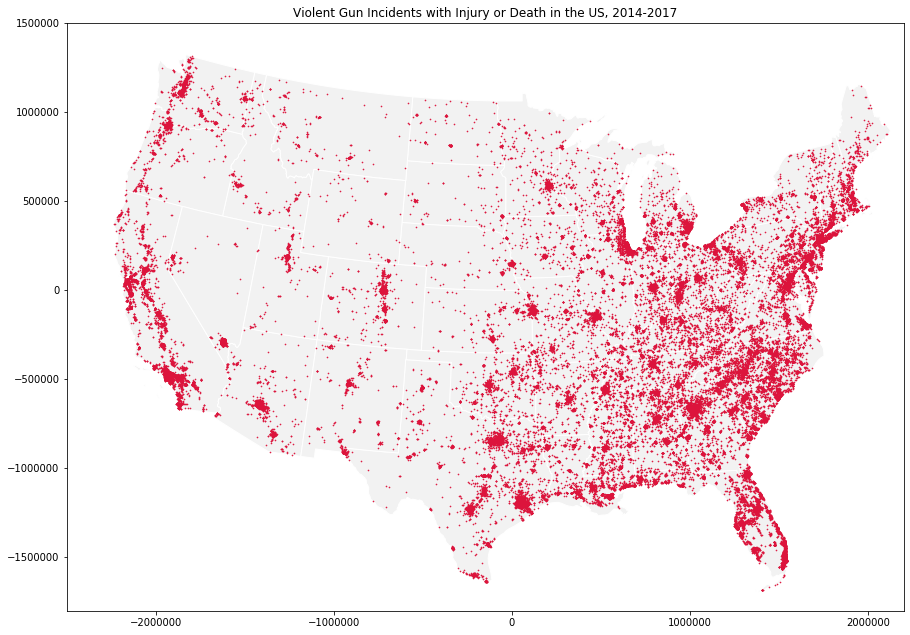

In [581]:
#create basic map to visualize data, showing each incident location over a state basemap

#read states into notebook to use as basemap
states = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip')

#project each layer to Albers Equal Conic for visualization
states_equal = states.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
incidents_equal = incidents.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

#plot projected data
fig, ax = plt.subplots()

states_equal.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0)
incidents_equal.plot(ax=ax, color='crimson', zorder=1, markersize=.4);

ax.set(xlim=(-2500000,2200000), ylim=(-1800000,1500000), title='Violent Gun Incidents with Injury or Death in the US, 2014-2017');

### Aggregate incidents by congressional district <a name="aggregate-incidents">

Now that I've seen all the incident locations on a map, I want to bring in a congressional district polygon layer so that I can aggregate the point locations by district. 

In [582]:
#read in congressional district shapefile
congress = gpd.read_file('https://opendata.arcgis.com/datasets/ff48bbae433442a38f6c635b8c7baf72_0.zip')

#look at data
pd.reset_option('display.max_colwidth')
congress.sample(5)

,OBJECTID,ID,NAME,ST_ABBREV,TOTPOP_CY,HHPOP_CY,FAMPOP_CY,GQPOP_CY,POPDENS_CY,TOTHH_CY,AVGHHSZ_CY,FAMHH_CY,AVGFMSZ_CY,TOTHU_CY,OWNER_CY,RENTER_CY,VACANT_CY,POPGRW10CY,HHGRW10CY,FAMGRW10CY,POP0_CY,POP5_CY,POP10_CY,POP15_CY,POP20_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,MALES_CY,FEMALES_CY,NOHS_CY,SOMEHS_CY,HSGRAD_CY,GED_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,NEVMARR_CY,MARRIED_CY,WIDOWED_CY,DIVORCD_CY,HINC0_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINC100_CY,HINC150_CY,HINC200_CY,MEDHINC_CY,AVGHINC_CY,PCI_CY,TOTPOP_FY,HHPOP_FY,FAMPOP_FY,GQPOP_FY,POPDENS_FY,TOTHH_FY,AVGHHSZ_FY,FAMHH_FY,AVGFMSZ_FY,TOTHU_FY,OWNER_FY,RENTER_FY,VACANT_FY,POPGRWCYFY,HHGRWCYFY,FAMGRWCYFY,PCIGRWCYFY,OWNGRWCYFY,MHIGRWCYFY,High_Inc,Low_Inc,GenZ_1,GenMil,GenX_1,GenBoom,GenSilent,geometry
41,42,0621,California - District 21,CA,723954,678948,605193,45006,107.6,182152,3.73,149488,4.05,197685,91066,91086,15533,0.47,0.47,0.46,68492,63064,59962,57862,65287,64000,55754,47651,43582,40956,38633,33912,26873,20656,14673,10049,6463,6087,386466,337490,108423,61549,89043,15704,76095,23593,24478,10402,215390,250407,23355,43284,28960,26471,24832,31437,30760,16822,14941,4872,3056,39009,53826,14135,750994,705989,629182,45005,111.6,188204,3.75,154472,4.07,204927,93172,95032,16723,0.74,0.66,0.66,1.04,0.46,0.05,7928,55431,214424,249274,118727,107636,33896,"POLYGON ((-119.681987478198 36.7002617917192, ..."
409,410,5107,Virginia - District 7,VA,773720,761601,633987,12119,278.7,294181,2.59,205304,3.09,317187,215017,79164,23006,0.99,0.90,0.82,44565,49665,53066,49457,43986,45438,48785,49680,52621,54584,58009,56574,49512,41504,28660,19114,13512,14984,375508,398208,17775,27800,107408,17464,105876,36758,133711,86188,174822,353172,35041,63387,19610,17440,21486,36235,53273,41668,56529,23585,24350,74365,95652,36749,817203,805084,669060,12119,294.3,309896,2.60,215745,3.10,334138,226405,83491,24242,1.10,1.05,1.00,1.56,1.04,1.98,47935,37050,167615,196894,150368,189258,69589,"POLYGON ((-77.81357053443701 38.5301366764101,..."
332,333,4208,Pennsylvania - District 8,PA,716002,707143,599851,8859,1012.8,268563,2.63,192204,3.12,283598,202277,66286,15035,0.23,0.22,0.12,36542,42564,47341,44269,37751,39514,41757,41387,45730,51699,58004,58252,48910,40060,28981,20393,15460,17388,351853,364149,9169,21812,143157,11601,89922,38386,117995,75493,167105,337207,35978,49265,15751,16060,17676,28133,45330,39819,54618,25833,25343,80676,104639,39524,724333,715474,605276,8859,1024.6,271584,2.63,193734,3.12,287810,204271,67313,16226,0.23,0.22,0.16,1.76,0.20,2.30,51176,31811,145053,169244,136983,189153,75565,"(POLYGON ((-74.9733884985064 40.0532783422857,..."
186,187,2405,Maryland - District 5,MD,767649,747189,623802,20460,518.2,263976,2.83,189899,3.28,285570,198690,65287,21594,1.02,0.89,0.78,43701,48257,52031,57455,55216,48815,49521,47516,50623,55721,59736,55607,45273,36540,25286,16345,10293,9714,375201,392449,16362,26809,127190,14839,114558,36552,100238,74442,220359,310706,30641,61954,13421,10142,12463,23120,42270,40130,62252,34065,26111,92655,109054,37995,809381,788921,657347,20460,546.4,277366,2.84,198884,3.31,300015,208495,68871,22649,1.06,0.99,0.93,1.64,0.97,2.04,60176,23563,164289,219072,149306,179267,55710,"(POLYGON ((-76.5038488705933 38.9024666799518,..."
151,152,1801,Indiana - District 1,IN,727466,711517,585801,15949,628.7,275105,2.59,186004,3.15,308914,189425,85680,33809,0.16,0.15,0.01,44619,46288,48858,47986,47553,46444,46896,45257,45461,46257,51079,53111,46854,38375,26766,18476,13237,13948,356770,370695,18727,34895,148151,23168,113492,43018,72496,38214,199056,279575,38244,70825,35423,28863,28483,37898,53912,36300,36603,10412,7201,52163,66787,25581,735020,719071,589863,15949,635.3,277942,2.59,187077,3.15,314918,191629,86313,36976,0.21,0.21,0.12,2.05,0.23,2.47,17613,64286,158953,196879,129787,175637,66210,"(POLYGON ((-87.5208034116223 41.7098270923748,..."


In [583]:
#check crs
#the crs is the same as the incident GeoDataFrame just created
print(congress.crs)

{'init': 'epsg:4326'}


Next I run a `for` loop that loops through each congressional district, finds the incidents that fall within the district, and populates new columns with column statistics from those incidents.

While working through my solution, I found that my code kept stalling when it tried to process Louisiana - District 1. I determined this was due to the highly irregular shape of this district. I tried several workarounds and decided the quickest solution would be to manually input the values for Louisiana District 1. So in the `for` loop that calculates values for the other districts, I included a conditional statement that skips Lousiana District 1.

In [587]:
%%time

shapely.speedups.enable()

#create new columns to populate after performing point in polygon operation
congress['incident_count'] = ''
congress['num_killed'] = ''
congress['num_injured'] = ''

#loop through each congressional district
#making special condition for Louisiana to speed up processing time
#find all the incidents within a district
for index, row in congress.iterrows():
    if row['NAME'] != 'Louisiana - District 1': #for all districts that aren't LA's first district
        pip_mask = incidents.within(row['geometry']) #assign those points to pip_mask variable
        pip_data = incidents.loc[pip_mask] #select those rows from the incidents GeoDataFrame
        
        #update values with count or sums of columns in the selected data
        congress.at[index, 'incident_count'] = pip_data['geometry'].count()
        congress.at[index, 'num_killed'] = pip_data['n_killed'].sum()
        congress.at[index, 'num_injured'] = pip_data['n_injured'].sum()
        print(row['NAME']) #print each district as code runs to monitor progress
    
    else: #skip LA district 1 to speed up processing
        print('skip LA district 1 for now')

Alabama - District 1
Alabama - District 2
Alabama - District 3
Alabama - District 4
Alabama - District 5
Alabama - District 6
Alabama - District 7
Alaska Congressional District
Arizona - District 1
Arizona - District 2
Arizona - District 3
Arizona - District 4
Arizona - District 5
Arizona - District 6
Arizona - District 7
Arizona - District 8
Arizona - District 9
Arkansas - District 1
Arkansas - District 2
Arkansas - District 3
Arkansas - District 4
California - District 1
California - District 2
California - District 3
California - District 4
California - District 5
California - District 6
California - District 7
California - District 8
California - District 9
California - District 10
California - District 11
California - District 12
California - District 13
California - District 14
California - District 15
California - District 16
California - District 17
California - District 18
California - District 19
California - District 20
California - District 21
California - District 22
Calif

Tennessee - District 1
Tennessee - District 2
Tennessee - District 3
Tennessee - District 4
Tennessee - District 5
Tennessee - District 6
Tennessee - District 7
Tennessee - District 8
Tennessee - District 9
Texas - District 1
Texas - District 2
Texas - District 3
Texas - District 4
Texas - District 5
Texas - District 6
Texas - District 7
Texas - District 8
Texas - District 9
Texas - District 10
Texas - District 11
Texas - District 12
Texas - District 13
Texas - District 14
Texas - District 15
Texas - District 16
Texas - District 17
Texas - District 18
Texas - District 19
Texas - District 20
Texas - District 21
Texas - District 22
Texas - District 23
Texas - District 24
Texas - District 25
Texas - District 26
Texas - District 27
Texas - District 28
Texas - District 29
Texas - District 30
Texas - District 31
Texas - District 32
Texas - District 33
Texas - District 34
Texas - District 35
Texas - District 36
Utah - District 1
Utah - District 2
Utah - District 3
Utah - District 4
Vermont Co

In [590]:
#check results
congress.sample(5)

,OBJECTID,ID,NAME,ST_ABBREV,TOTPOP_CY,HHPOP_CY,FAMPOP_CY,GQPOP_CY,POPDENS_CY,TOTHH_CY,AVGHHSZ_CY,FAMHH_CY,AVGFMSZ_CY,TOTHU_CY,OWNER_CY,RENTER_CY,VACANT_CY,POPGRW10CY,HHGRW10CY,FAMGRW10CY,POP0_CY,POP5_CY,POP10_CY,POP15_CY,POP20_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,MALES_CY,FEMALES_CY,NOHS_CY,SOMEHS_CY,HSGRAD_CY,GED_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,NEVMARR_CY,MARRIED_CY,WIDOWED_CY,DIVORCD_CY,HINC0_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINC100_CY,HINC150_CY,HINC200_CY,MEDHINC_CY,AVGHINC_CY,PCI_CY,TOTPOP_FY,HHPOP_FY,FAMPOP_FY,GQPOP_FY,POPDENS_FY,TOTHH_FY,AVGHHSZ_FY,FAMHH_FY,AVGFMSZ_FY,TOTHU_FY,OWNER_FY,RENTER_FY,VACANT_FY,POPGRWCYFY,HHGRWCYFY,FAMGRWCYFY,PCIGRWCYFY,OWNGRWCYFY,MHIGRWCYFY,High_Inc,Low_Inc,GenZ_1,GenMil,GenX_1,GenBoom,GenSilent,geometry,incident_count,num_killed,num_injured
416,417,5303,Washington - District 3,WA,710733,704593,573458,6140,78.0,269409,2.62,184947,3.10,298151,178317,91091,28742,0.89,0.76,0.70,44699,46040,48415,45616,42251,43573,44160,44443,45478,45549,48950,50350,47153,41357,29046,18586,12051,13014,352030,358701,15848,31138,108664,21077,138051,53542,74717,40675,153728,313220,31248,73384,28148,25117,26788,39142,54552,35959,37155,12758,9789,55144,72764,27807,745199,739059,600754,6140,81.8,281602,2.62,193093,3.11,311851,185934,95668,30249,0.95,0.89,0.87,1.83,0.84,1.78,22547,53265,158045,183282,128174,175276,65958,"(POLYGON ((-122.327760000164 45.5564400001296,...",128,70,87
171,172,2104,Kentucky - District 4,KY,753752,736432,610379,17320,172.2,283068,2.60,196419,3.11,312367,197642,85426,29299,0.66,0.54,0.36,47455,50392,52123,47733,44769,47140,48982,49083,50574,51759,55052,53733,47008,39150,27123,18197,12016,11464,373988,379765,20616,36796,132510,32086,111350,42434,85109,50379,164924,327199,35713,75945,34474,28166,26479,37657,52576,37903,40543,13191,12077,55152,74040,28219,779646,762326,629889,17320,178.2,291679,2.61,201462,3.13,321916,203877,87802,30237,0.68,0.60,0.51,1.79,0.62,2.19,25268,62640,169374,198568,143906,179440,62460,"POLYGON ((-84.49615557411759 39.1012194941148,...",133,81,90
218,219,2706,Minnesota - District 6,MN,699640,685128,574281,14512,242.7,251724,2.72,181850,3.16,269681,202151,49573,17957,0.86,0.89,0.81,47357,50477,52164,49213,48777,43813,47456,47259,47828,49331,52378,47278,37684,29630,19779,12671,8227,8318,352428,347212,8139,18227,107905,14614,109061,60460,93502,39747,166048,310977,21388,51230,17092,14652,17445,29027,50281,41024,51508,18388,12296,73139,88774,32251,736373,721861,603670,14512,255.5,265148,2.72,191091,3.16,284230,212948,52200,19082,1.03,1.04,1.00,1.84,1.05,2.33,30684,31744,169669,197919,137065,150701,44276,"POLYGON ((-92.745690626388 45.2960500696752, -...",55,24,41
405,406,5103,Virginia - District 3,VA,756133,723972,533831,32161,798.4,301370,2.40,175150,3.05,337265,142727,158642,35895,0.20,0.64,0.43,49286,47178,43659,51547,73782,67014,56054,45717,42179,43395,48859,48845,41997,33393,23354,16331,11319,12223,362949,393183,25772,49650,115947,25137,120620,35981,72979,44595,278190,224593,38003,75224,53028,36315,37381,49552,53865,32081,25745,7342,6048,40978,54575,22420,780427,748267,548599,32160,824.0,311549,2.40,179574,3.06,349065,146645,164904,37516,0.63,0.67,0.50,0.78,0.54,-0.73,13390,89343,156523,260167,122293,159369,57787,"(POLYGON ((-76.2963265810519 36.7982463438539,...",1831,544,1682
35,36,0615,California - District 15,CA,755483,742866,635268,12617,1260.2,250445,2.97,186335,3.41,260803,156526,93920,10358,1.16,1.01,1.02,48841,52602,54023,48070,44650,48349,52967,54403,56219,54555,55157,50903,41632,33332,22950,15401,10201,11228,373799,381684,29648,25307,94687,9032,99007,39256,132621,77738,187355,333466,29849,49347,16236,13277,13914,21837,36328,31008,51371,31440,35032,92794,118875,39922,806016,793400,678554,12616,1344.5,266048,2.98,198005,3.43,276151,166031,100017,10103,1.30,1.22,1.22,1.52,1.19,2.23,66472,29513,175341,206595,154947,164209,54387,"POLYGON ((-121.5569

Now I'll inspect Louisiana District 1 further to see why it was stalling the point in polygon operation I ran above.

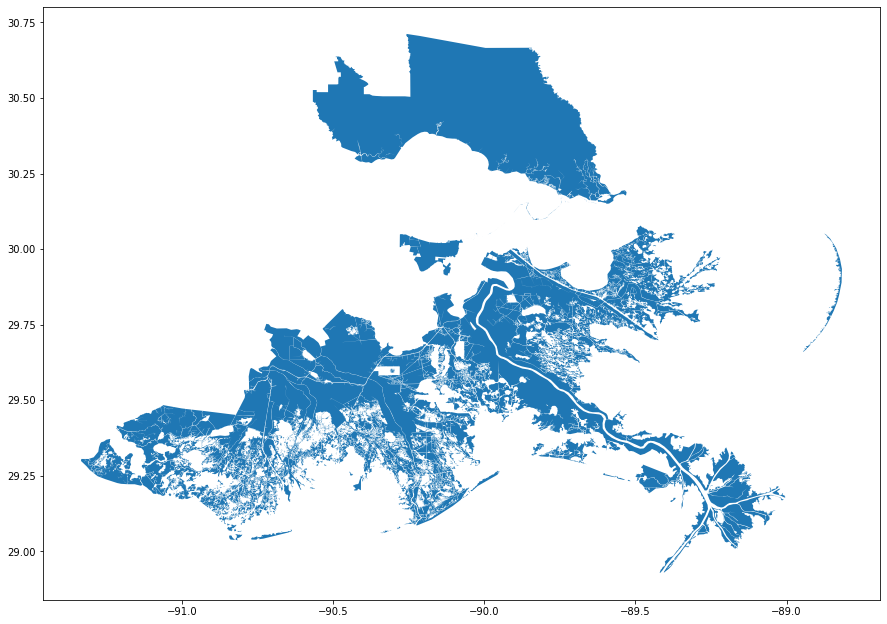

In [591]:
#look at Louisiana's first district to visualize problem
#complex geometry shape was stalling process
LA_district1 = congress.loc[congress['NAME'] == 'Louisiana - District 1']
LA_district1.plot()

In [593]:
%%time

#select incidents from Louisiana's first district
#I will use this subset to calculate statistics for this district
LA_district1_incidents = incidents.loc[(incidents['state'] == 'Louisiana') & (incidents['congressional_district'] == 1.0)]
LA_district1_incidents.head()

Wall time: 21.9 ms


,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,congressional_district,incident_characteristics,latitude,location_description,longitude,notes,sources,state_house_district,state_senate_district,year,month,geometry
782,93145,2014-01-04,Louisiana,Metairie,1300 block of Pier Avenue,1,0,http://www.gunviolencearchive.org/incident/93145,http://www.wwltv.com/news/crime/JP-deputy-shoo...,1.0,"Shot - Dead (murder, accidental, suicide)||Off...",30.0138,NaN,-90.1353,"Appeared to be a case of ""suicide by cop,"" acc...",http://www.wwltv.com/news/crime/JP-deputy-shoo...,94.0,9.0,2014,1,POINT (-90.1353 30.0138)
908,93459,2014-01-05,Louisiana,Metairie,2800 block of Independence Street,0,1,http://www.gunviolencearchive.org/incident/93459,/%20http%3A//www.nola.com/crime/index.ssf/2014...,1.0,Shot - Wounded/Injured,30.0003,NaN,-90.1780,NaN,NaN,80.0,9.0,2014,1,POINT (-90.178 30.0003)
1030,94032,2014-01-06,Louisiana,Covington,72525 Carnation St,2,0,http://www.gunviolencearchive.org/incident/94032,http://www.wwltv.com/news/local/northshore/son...,1.0,"Shot - Dead (murder, accidental, suicide)||Dom...",30.4846,NaN,-90.0450,2 killed.,http://www.nola.com/crime/index.ssf/2014/01/te...,74.0,11.0,2014,1,POINT (-90.045 30.4846)
1443,94312,2014-01-09,Louisiana,New Orleans,Hewes and Calhoun streets,1,0,http://www.gunviolencearchive.org/incident/94312,http://www.nola.com/crime/index.ssf/2014/01/co...,1.0,"Shot - Dead (murder, accidental, suicide)||Dom...",29.9510,NaN,-90.1113,NaN,http://www.nola.com/crime/index.ssf/2014/01/1_...,91.0,5.0,2014,1,POINT (-90.1113 29.951)
3546,100107,2014-01-23,Louisiana,Natalbany,NaN,1,0,http://www.gunviolencearchive.org/incident/100107,http://www.wafb.com/story/24540512/teen-dead-a...,1.0,"Shot - Dead (murder, accidental, suicide)||Bar...",30.5457,Roy's Night Club,-90.4815,Royâ€™s Night Club,http://www.wafb.com/story/24540512/teen-dead-a...,86.0,6.0,2014,1,POINT (-90.4815 30.5457)


In [602]:
#calculate statistics on the subset
#there are 252 violent gun incidents in Louisiana District 1
print(LA_district1_incidents['incident_id'].count())

#there are 122 deaths
print(LA_district1_incidents['n_killed'].sum())

#and 191 injuries
print(LA_district1_incidents['n_injured'].sum())

252
122
191


In [617]:
#run for loop again, but this time only selecting Louisiana District 1
#and explicitly declaring the statistic columns
for index, row in congress.iterrows():
    if row['NAME'] == 'Louisiana - District 1':      
        congress.at[index, 'incident_count'] = 252
        congress.at[index, 'num_killed'] = 122
        congress.at[index, 'num_injured'] = 191

#check results
congress.loc[congress['NAME'] == 'Louisiana - District 1']

,OBJECTID,ID,NAME,ST_ABBREV,TOTPOP_CY,HHPOP_CY,FAMPOP_CY,GQPOP_CY,POPDENS_CY,TOTHH_CY,AVGHHSZ_CY,FAMHH_CY,AVGFMSZ_CY,TOTHU_CY,OWNER_CY,RENTER_CY,VACANT_CY,POPGRW10CY,HHGRW10CY,FAMGRW10CY,POP0_CY,POP5_CY,POP10_CY,POP15_CY,POP20_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,MALES_CY,FEMALES_CY,NOHS_CY,SOMEHS_CY,HSGRAD_CY,GED_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,NEVMARR_CY,MARRIED_CY,WIDOWED_CY,DIVORCD_CY,HINC0_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINC100_CY,HINC150_CY,HINC200_CY,MEDHINC_CY,AVGHINC_CY,PCI_CY,TOTPOP_FY,HHPOP_FY,FAMPOP_FY,GQPOP_FY,POPDENS_FY,TOTHH_FY,AVGHHSZ_FY,FAMHH_FY,AVGFMSZ_FY,TOTHU_FY,OWNER_FY,RENTER_FY,VACANT_FY,POPGRWCYFY,HHGRWCYFY,FAMGRWCYFY,PCIGRWCYFY,OWNGRWCYFY,MHIGRWCYFY,High_Inc,Low_Inc,GenZ_1,GenMil,GenX_1,GenBoom,GenSilent,geometry,incident_count,num_killed,num_injured
174,175,2201,Louisiana - District 1,LA,799380,788360,634510,11020,198.3,312291,2.52,206857,3.07,348807,207825,104467,36516,0.91,1.02,0.77,48737,50705,50525,49157,51131,55317,56430,50695,49072,50284,56055,57754,51491,42749,29901,20050,14202,15125,392449,406931,29113,45619,137102,24665,120989,30659,104845,56131,211389,320265,41358,76401,38321,31399,32227,41788,53445,37004,44644,16791,16659,54233,77322,30554,838064,827044,662666,11020,207.9,328559,2.52,215997,3.07,365969,218829,109730,37410,0.95,1.02,0.87,1.67,1.04,2.06,33450,69720,168773,224037,141160,193096,72313,"(POLYGON ((-90.3978398417903 30.3162901337141,...",252,122,191


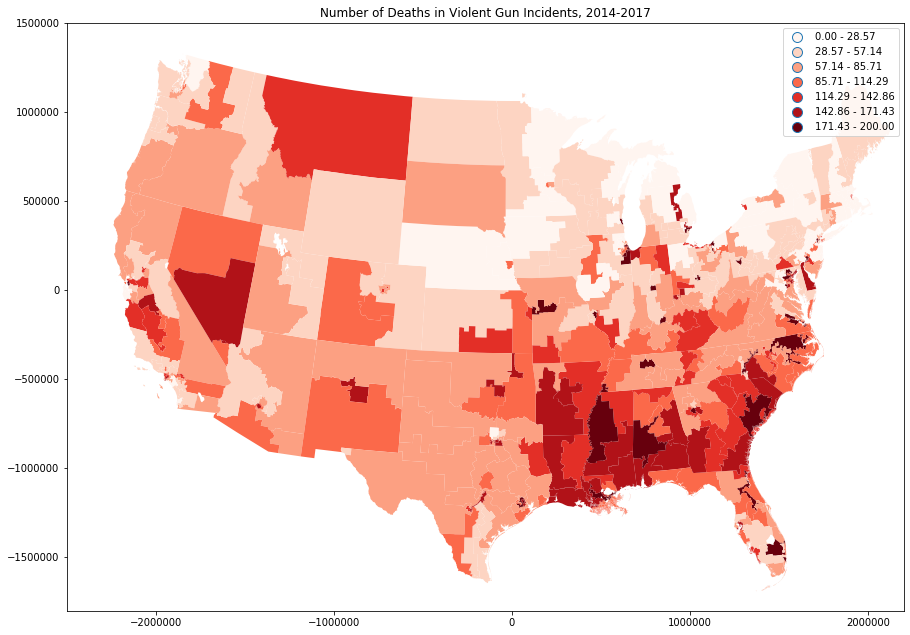

In [625]:
#plot chloropleth map visualizing aggregated data

#project to Albers Equal Area Conic
congress_equal = congress.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

# vmin, vmax = 0, 962

variable = 'num_killed'

fig, ax = plt.subplots()

congress_equal.plot(ax=ax, column=variable, cmap='Reds', legend=True, scheme='equal_interval', k=7);

ax.set(xlim=(-2500000,2200000), ylim=(-1800000,1500000), title='Number of Deaths in Violent Gun Incidents, 2014-2017');

### Join legislator contact list to congressional district GeoDataFrame <a name="join-contact-list">

While thinking about how this data would look as a webmap, I thought it would be useful to have some information in a popup for each district. I found data on current legislators that includes their website URL, as well as address and phone number. This data is hosted on Github, [congress-legislators](https://github.com/unitedstates/congress-legislators).

In [626]:
#read data into notebook
contacts = pd.read_csv('https://theunitedstates.io/congress-legislators/legislators-current.csv')
contacts.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,district,senate_class,party,url,address,phone,contact_form,rss_url,twitter,facebook,youtube,youtube_id,bioguide_id,thomas_id,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,Brown,Sherrod,NaN,NaN,NaN,Sherrod Brown,1952-11-09,M,sen,OH,NaN,1.0,Democrat,https://www.brown.senate.gov,503 Hart Senate Office Building Washington DC ...,202-224-2315,http://www.brown.senate.gov/contact/,http://www.brown.senate.gov/rss/feeds/?type=al...,SenSherrodBrown,SenatorSherrodBrown,SherrodBrownOhio,UCgy8jfERh-t_ixkKKoCmglQ,B000944,136.0,N00003535,S307,"H2OH13033,S6OH00163",5051.0,400050,27018.0,Sherrod Brown,NaN,29389.0,Sherrod Brown
1,Cantwell,Maria,NaN,NaN,NaN,Maria Cantwell,1958-10-13,F,sen,WA,NaN,1.0,Democrat,https://www.cantwell.senate.gov,511 Hart Senate Office Building Washington DC ...,202-224-3441,http://www.cantwell.senate.gov/public/index.cf...,http://www.cantwell.senate.gov/public/index.cf...,SenatorCantwell,senatorcantwell,SenatorCantwell,UCN52UDqKgvHRk39ncySrIMw,C000127,172.0,N00007836,S275,"S8WA00194,H2WA01054",26137.0,300018,27122.0,Maria Cantwell,NaN,39310.0,Maria Cantwell
2,Cardin,Benjamin,L.,NaN,NaN,Benjamin L. Cardin,1943-10-05,M,sen,MD,NaN,1.0,Democrat,https://www.cardin.senate.gov,509 Hart Senate Office Building Washington DC ...,202-224-4524,http://www.cardin.senate.gov/contact/,http://www.cardin.senate.gov/rss/feeds/?type=all,SenatorCardin,senatorbencardin,senatorcardin,UCiQaJnMzlfzzG3VESgyZChA,C000141,174.0,N00001955,S308,"H6MD03177,S6MD03177",4004.0,400064,26888.0,Ben Cardin,NaN,15408.0,Ben Cardin
3,Carper,Thomas,Richard,NaN,NaN,Thomas R. Carper,1947-01-23,M,sen,DE,NaN,1.0,Democrat,https://www.carper.senate.gov/public,513 Hart Senate Office Building Washington DC ...,202-224-2441,http://www.carper.senate.gov/public/index.cfm/...,http://www.carper.senate.gov/public/index.cfm/...,SenatorCarper,tomcarper,senatorcarper,UCgLnvbKwu4B3navofj6Qvvw,C000174,179.0,N00012508,S277,S8DE00079,663.0,300019,22421.0,Tom Carper,NaN,15015.0,Tom Carper
4,Casey,Robert,P.,Jr.,Bob,"Robert P. Casey, Jr.",1960-04-13,M,sen,PA,NaN,1.0,Democrat,https://www.casey.senate.gov,393 Russell Senate Office Building Washington ...,202-224-6324,https://www.casey.senate.gov/contact/,http://www.casey.senate.gov/rss/feeds/?all,SenBobCasey,SenatorBobCasey,SenatorBobCasey,UCtVssXhx-KuZa-hSvnsnJ0A,C001070,1828.0,N00027503,S309,S6PA00217,47036.0,412246,2541.0,"Bob Casey, Jr.",NaN,40703.0,Bob Casey Jr.


I will need a common field to join this new contact data to the congressional district shapefile. A quick look at the contact data shows a `state` field that contains the state abbreviation, and a `district` field that contains the district number. My congress data has a `ST_ABBREV` field and a `NAME` field, which contains the state full name and the district number. I think my best bet is to wrangle the data so each set has a new field that contains both the state abbreviation and the district number.

In [627]:
#the contact list also contains senators, whose district number is a null value
#pull out just representatives
reps = contacts.loc[contacts['type'] =='rep']
reps.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,district,senate_class,party,url,address,phone,contact_form,rss_url,twitter,facebook,youtube,youtube_id,bioguide_id,thomas_id,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
32,Aderholt,Robert,B.,NaN,NaN,Robert B. Aderholt,1965-07-22,M,rep,AL,4.0,NaN,Republican,https://aderholt.house.gov,1203 Longworth House Office Building; Washingt...,202-225-4876,NaN,http://aderholt.house.gov/common/rss//index.cf...,Robert_Aderholt,RobertAderholt,RobertAderholt,UC71CAgpg1gbLTew_pfTneGA,A000055,1460.0,N00003028,NaN,H6AL04098,45516.0,400004,441.0,Robert B. Aderholt,NaN,29701.0,Robert Aderholt
33,Amash,Justin,NaN,NaN,NaN,Justin Amash,1980-04-18,M,rep,MI,3.0,NaN,Independent,https://amash.house.gov,106 Cannon House Office Building; Washington D...,202-225-3831,NaN,http://amash.house.gov/rss.xml,NaN,repjustinamash,repjustinamash,UCeg6HhoCXrS8xpON9dxtZgA,A000367,2029.0,N00031938,NaN,H0MI03126,1033767.0,412438,105566.0,Justin Amash,NaN,21143.0,Justin Amash
35,Bass,Karen,NaN,NaN,NaN,Karen Bass,1953-10-03,F,rep,CA,37.0,NaN,Democrat,https://bass.house.gov,2059 Rayburn House Office Building; Washington...,202-225-7084,NaN,http://bass.house.gov/rss.xml,RepKarenBass,RepKarenBass,RepKarenBass,UCQZg7oxkV3Yag2emYPLhT2g,B001270,1996.0,N00031877,NaN,H0CA33117,62502.0,412404,28963.0,NaN,NaN,21110.0,Karen Bass
37,Bilirakis,Gus,M.,NaN,NaN,Gus M. Bilirakis,1963-02-08,M,rep,FL,12.0,NaN,Republican,https://bilirakis.house.gov,2227 Rayburn House Office Building; Washington...,202-225-5755,NaN,http://bilirakis.house.gov/index.php?format=fe...,RepGusBilirakis,GusBilirakis,RepGusBilirakis,UC2z1uu1n4-60xXs5x1mvLJw,B001257,1838.0,N00027462,NaN,H6FL09070,1022873.0,412250,17318.0,Gus M. Bilirakis,NaN,20758.0,Gus Bilirakis
38,Bishop,Rob,NaN,NaN,NaN,Rob Bishop,1951-07-13,M,rep,UT,1.0,NaN,Republican,https://robbishop.house.gov,123 Cannon House Office Building; Washington D...,202-225-0453,NaN,http://robbishop.house.gov/news/rss.aspx,RepRobBishop,RepRobBishop,CongressmanBishop,UCJC2BXNGQEUom7Tp7FKfxlQ,B001250,1753.0,N00025292,NaN,H2UT01094,1003621.0,400029,50544.0,Rob Bishop,NaN,20357.0,Rob Bishop


In [628]:
#I know that some states only have one district
#I need to know how that is represented in this dataset
#pull out Wyoming and see that states with only one district are denoted by a 0
WY = reps.loc[reps['state'] == 'WY']
WY

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,district,senate_class,party,url,address,phone,contact_form,rss_url,twitter,facebook,youtube,youtube_id,bioguide_id,thomas_id,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
427,Cheney,Liz,NaN,NaN,NaN,Liz Cheney,1966-07-28,F,rep,WY,0.0,NaN,Republican,https://cheney.house.gov,416 Cannon House Office Building; Washington D...,202-225-2311,NaN,NaN,RepLizCheney,replizcheney,NaN,UCvL57Zp99QdDllF-KGziUAA,C001109,NaN,N00035504,NaN,H6WY00159,86147.0,412732,171319.0,NaN,NaN,21710.0,Liz Cheney


In [629]:
#the district field contains a decimal point
#first convert district field to integer type to remove decimal
reps['district'] = reps['district'].astype(int)

#then convert district field to string type so it can be concatenated to the state abbreviation
reps['district'] = reps['district'].astype(str)
reps.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,district,senate_class,party,url,address,phone,contact_form,rss_url,twitter,facebook,youtube,youtube_id,bioguide_id,thomas_id,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
32,Aderholt,Robert,B.,NaN,NaN,Robert B. Aderholt,1965-07-22,M,rep,AL,4,NaN,Republican,https://aderholt.house.gov,1203 Longworth House Office Building; Washingt...,202-225-4876,NaN,http://aderholt.house.gov/common/rss//index.cf...,Robert_Aderholt,RobertAderholt,RobertAderholt,UC71CAgpg1gbLTew_pfTneGA,A000055,1460.0,N00003028,NaN,H6AL04098,45516.0,400004,441.0,Robert B. Aderholt,NaN,29701.0,Robert Aderholt
33,Amash,Justin,NaN,NaN,NaN,Justin Amash,1980-04-18,M,rep,MI,3,NaN,Independent,https://amash.house.gov,106 Cannon House Office Building; Washington D...,202-225-3831,NaN,http://amash.house.gov/rss.xml,NaN,repjustinamash,repjustinamash,UCeg6HhoCXrS8xpON9dxtZgA,A000367,2029.0,N00031938,NaN,H0MI03126,1033767.0,412438,105566.0,Justin Amash,NaN,21143.0,Justin Amash
35,Bass,Karen,NaN,NaN,NaN,Karen Bass,1953-10-03,F,rep,CA,37,NaN,Democrat,https://bass.house.gov,2059 Rayburn House Office Building; Washington...,202-225-7084,NaN,http://bass.house.gov/rss.xml,RepKarenBass,RepKarenBass,RepKarenBass,UCQZg7oxkV3Yag2emYPLhT2g,B001270,1996.0,N00031877,NaN,H0CA33117,62502.0,412404,28963.0,NaN,NaN,21110.0,Karen Bass
37,Bilirakis,Gus,M.,NaN,NaN,Gus M. Bilirakis,1963-02-08,M,rep,FL,12,NaN,Republican,https://bilirakis.house.gov,2227 Rayburn House Office Building; Washington...,202-225-5755,NaN,http://bilirakis.house.gov/index.php?format=fe...,RepGusBilirakis,GusBilirakis,RepGusBilirakis,UC2z1uu1n4-60xXs5x1mvLJw,B001257,1838.0,N00027462,NaN,H6FL09070,1022873.0,412250,17318.0,Gus M. Bilirakis,NaN,20758.0,Gus Bilirakis
38,Bishop,Rob,NaN,NaN,NaN,Rob Bishop,1951-07-13,M,rep,UT,1,NaN,Republican,https://robbishop.house.gov,123 Cannon House Office Building; Washington D...,202-225-0453,NaN,http://robbishop.house.gov/news/rss.aspx,RepRobBishop,RepRobBishop,CongressmanBishop,UCJC2BXNGQEUom7Tp7FKfxlQ,B001250,1753.0,N00025292,NaN,H2UT01094,1003621.0,400029,50544.0,Rob Bishop,NaN,20357.0,Rob Bishop


In [630]:
#create new field that will contain both the state abbreviation and district number
reps['join_by'] = reps['state'] + ' ' + reps['district']
reps.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,district,senate_class,party,url,address,phone,contact_form,rss_url,twitter,facebook,youtube,youtube_id,bioguide_id,thomas_id,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id,join_by
32,Aderholt,Robert,B.,NaN,NaN,Robert B. Aderholt,1965-07-22,M,rep,AL,4,NaN,Republican,https://aderholt.house.gov,1203 Longworth House Office Building; Washingt...,202-225-4876,NaN,http://aderholt.house.gov/common/rss//index.cf...,Robert_Aderholt,RobertAderholt,RobertAderholt,UC71CAgpg1gbLTew_pfTneGA,A000055,1460.0,N00003028,NaN,H6AL04098,45516.0,400004,441.0,Robert B. Aderholt,NaN,29701.0,Robert Aderholt,AL 4
33,Amash,Justin,NaN,NaN,NaN,Justin Amash,1980-04-18,M,rep,MI,3,NaN,Independent,https://amash.house.gov,106 Cannon House Office Building; Washington D...,202-225-3831,NaN,http://amash.house.gov/rss.xml,NaN,repjustinamash,repjustinamash,UCeg6HhoCXrS8xpON9dxtZgA,A000367,2029.0,N00031938,NaN,H0MI03126,1033767.0,412438,105566.0,Justin Amash,NaN,21143.0,Justin Amash,MI 3
35,Bass,Karen,NaN,NaN,NaN,Karen Bass,1953-10-03,F,rep,CA,37,NaN,Democrat,https://bass.house.gov,2059 Rayburn House Office Building; Washington...,202-225-7084,NaN,http://bass.house.gov/rss.xml,RepKarenBass,RepKarenBass,RepKarenBass,UCQZg7oxkV3Yag2emYPLhT2g,B001270,1996.0,N00031877,NaN,H0CA33117,62502.0,412404,28963.0,NaN,NaN,21110.0,Karen Bass,CA 37
37,Bilirakis,Gus,M.,NaN,NaN,Gus M. Bilirakis,1963-02-08,M,rep,FL,12,NaN,Republican,https://bilirakis.house.gov,2227 Rayburn House Office Building; Washington...,202-225-5755,NaN,http://bilirakis.house.gov/index.php?format=fe...,RepGusBilirakis,GusBilirakis,RepGusBilirakis,UC2z1uu1n4-60xXs5x1mvLJw,B001257,1838.0,N00027462,NaN,H6FL09070,1022873.0,412250,17318.0,Gus M. Bilirakis,NaN,20758.0,Gus Bilirakis,FL 12
38,Bishop,Rob,NaN,NaN,NaN,Rob Bishop,1951-07-13,M,rep,UT,1,NaN,Republican,https://robbishop.house.gov,123 Cannon House Office Building; Washington D...,202-225-0453,NaN,http://robbishop.house.gov/news/rss.aspx,RepRobBishop,RepRobBishop,CongressmanBishop,UCJC2BXNGQEUom7Tp7FKfxlQ,B001250,1753.0,N00025292,NaN,H2UT01094,1003621.0,400029,50544.0,Rob Bishop,NaN,20357.0,Rob Bishop,UT 1


Now I need to create that same field in the congress GeoDataFrame. This data has the `NAME` field which contains the state full name and the district number. First I will pull out the district number.

In [631]:
#first create copy of congress gdf in case I need to go back to this point
congress_copy = congress.copy()

#create new empty field to populate
congress_copy['district'] = ''

#loop through each record, pulling out the district number and populating the district field
for index, row in congress_copy.iterrows():
    string = row['NAME']
    number = [int(i) for i in string.split() if i.isdigit()] #returns list of each number in the string
    if len(number) == 1: #if that list has only one number
        congress_copy.at[index, 'district'] = number[0] #return the first (and only) value in that string
    else: #unless the list is empty, meaning that state only has one district
        congress_copy.at[index, 'district'] = 0 #return a 0

#convert district field to str so it can be concatenated with the state abbreviation field
congress_copy['district'] = congress_copy['district'].astype(str)
congress_copy.head()

,OBJECTID,ID,NAME,ST_ABBREV,TOTPOP_CY,HHPOP_CY,FAMPOP_CY,GQPOP_CY,POPDENS_CY,TOTHH_CY,AVGHHSZ_CY,FAMHH_CY,AVGFMSZ_CY,TOTHU_CY,OWNER_CY,RENTER_CY,VACANT_CY,POPGRW10CY,HHGRW10CY,FAMGRW10CY,POP0_CY,POP5_CY,POP10_CY,POP15_CY,POP20_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,MALES_CY,FEMALES_CY,NOHS_CY,SOMEHS_CY,HSGRAD_CY,GED_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,NEVMARR_CY,MARRIED_CY,WIDOWED_CY,DIVORCD_CY,HINC0_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINC100_CY,HINC150_CY,HINC200_CY,MEDHINC_CY,AVGHINC_CY,PCI_CY,TOTPOP_FY,HHPOP_FY,FAMPOP_FY,GQPOP_FY,POPDENS_FY,TOTHH_FY,AVGHHSZ_FY,FAMHH_FY,AVGFMSZ_FY,TOTHU_FY,OWNER_FY,RENTER_FY,VACANT_FY,POPGRWCYFY,HHGRWCYFY,FAMGRWCYFY,PCIGRWCYFY,OWNGRWCYFY,MHIGRWCYFY,High_Inc,Low_Inc,GenZ_1,GenMil,GenX_1,GenBoom,GenSilent,geometry,incident_count,num_killed,num_injured,district
0,1,0101,Alabama - District 1,AL,717837,704571,583505,13266,118.3,280271,2.51,191687,3.04,345369,191383,88889,65098,0.80,0.89,0.74,44317,45363,46430,45111,46034,46924,45946,43501,44091,45066,49448,50869,46226,40900,30217,20893,13560,12940,349168,368668,19908,45241,138986,25771,107791,40432,73829,38624,175182,291670,40829,74045,47015,35059,32298,39552,51689,31280,27338,8699,7342,43658,60344,23880,747899,734633,606687,13266,123.3,293030,2.51,199572,3.04,363523,200427,92603,70493,0.82,0.89,0.81,1.89,0.93,1.97,16041,82074,153999,192299,125902,174921,70716,"(POLYGON ((-88.2740799987002 30.2319500000112,...",525,254,371,1
1,2,0102,Alabama - District 2,AL,700843,678088,555536,22755,69.1,275117,2.46,184343,3.01,318462,182005,93112,43345,0.42,0.40,0.25,43286,43803,44050,43250,48376,49472,47585,43810,44250,44188,47352,47558,43355,37929,27845,19410,12958,12366,342724,358119,25268,49470,126836,31334,101667,39123,64575,39803,175753,279029,40989,73934,48874,34568,32701,39918,48450,29964,27023,8226,5387,41838,57535,23075,709892,687137,561345,22755,70.0,278598,2.47,185833,3.02,324401,184375,94223,45803,0.26,0.25,0.16,1.69,0.26,1.68,13613,83442,147721,198552,124496,163829,66245,"POLYGON ((-85.0560331054993 32.0630610449913, ...",461,211,354,2
2,3,0103,Alabama - District 3,AL,717877,698711,565972,19166,95.2,282710,2.47,187981,3.01,333923,192327,90384,51213,0.80,0.76,0.59,42378,43667,43919,48366,59901,47279,45566,44032,44980,45245,48032,49112,44941,39691,28317,19115,12365,10975,352158,365723,26639,52528,130242,29720,103691,37496,59730,39602,179443,295748,40240,72482,53231,37514,34118,39908,49024,29889,26018,7638,5361,40059,55791,22365,744012,724846,584538,19166,98.6,292725,2.48,193421,3.02,347074,198480,94245,54349,0.72,0.70,0.57,1.62,0.63,1.25,12999,90745,147038,210477,126777,169330,64252,"POLYGON ((-85.4740283924739 34.3445557176351, ...",324,225,204,3
3,4,0104,Alabama - District 4,AL,694346,685737,574661,8609,78.1,275500,2.49,191464,3.00,318708,199856,75645,43208,0.27,0.25,0.10,41368,43227,43915,40784,39864,42698,42856,42385,44890,45242,48207,49374,46149,42070,31831,22207,14432,12846,341899,352446,35538,57333,135558,32814,105625,40820,47569,29929,134823,313248,45143,72622,50159,39932,34222,42111,48059,27250,22837,6042,4888,38746,53854,21593,701558,692949,579170,8609,78.9,278149,2.49,192436,3.01,323164,201763,76387,45015,0.21,0.19,0.10,1.67,0.19,1.17,10930,90091,145017,174948,126242,173988,74147,"POLYGON ((-85.5831497153746 34.8603786562608, ...",194,104,138,4
4,5,0105,Alabama - District 5,AL,721268,705942,582285,15326,196.1,289053,2.44,194767,2.99,320106,199815,89238,31053,0.88,0.90,0.74,41275,43801,45749,45964,47550,47221,47358,44956,46091,48209,53591,52076,44622,38130,28839,20376,13512,11947,354789,366478,21915,42788,109788,28365,106523,38868,93057,55623,168246,311190,37595,73410,39616,33068,30905,38985,49777,33099,38766,14554,10282,50659,69509,28197,750701,735375,604824,15326,204.1,301036,2.44,201874,3.00,334466,208302,92733,33430,0.80,0.82,0.72,1.82,0.84,1.81,24836,72684,148287,197622,133395,173788,68177,"POLYGON ((-86.8363108608838 34.991905

In [632]:
#create new field with state abbreviation and congressional district
congress_copy['join_by'] = congress_copy['ST_ABBREV'] + ' ' + congress_copy['district']
congress_copy.head()

,OBJECTID,ID,NAME,ST_ABBREV,TOTPOP_CY,HHPOP_CY,FAMPOP_CY,GQPOP_CY,POPDENS_CY,TOTHH_CY,AVGHHSZ_CY,FAMHH_CY,AVGFMSZ_CY,TOTHU_CY,OWNER_CY,RENTER_CY,VACANT_CY,POPGRW10CY,HHGRW10CY,FAMGRW10CY,POP0_CY,POP5_CY,POP10_CY,POP15_CY,POP20_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,MALES_CY,FEMALES_CY,NOHS_CY,SOMEHS_CY,HSGRAD_CY,GED_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,NEVMARR_CY,MARRIED_CY,WIDOWED_CY,DIVORCD_CY,HINC0_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINC100_CY,HINC150_CY,HINC200_CY,MEDHINC_CY,AVGHINC_CY,PCI_CY,TOTPOP_FY,HHPOP_FY,FAMPOP_FY,GQPOP_FY,POPDENS_FY,TOTHH_FY,AVGHHSZ_FY,FAMHH_FY,AVGFMSZ_FY,TOTHU_FY,OWNER_FY,RENTER_FY,VACANT_FY,POPGRWCYFY,HHGRWCYFY,FAMGRWCYFY,PCIGRWCYFY,OWNGRWCYFY,MHIGRWCYFY,High_Inc,Low_Inc,GenZ_1,GenMil,GenX_1,GenBoom,GenSilent,geometry,incident_count,num_killed,num_injured,district,join_by
0,1,0101,Alabama - District 1,AL,717837,704571,583505,13266,118.3,280271,2.51,191687,3.04,345369,191383,88889,65098,0.80,0.89,0.74,44317,45363,46430,45111,46034,46924,45946,43501,44091,45066,49448,50869,46226,40900,30217,20893,13560,12940,349168,368668,19908,45241,138986,25771,107791,40432,73829,38624,175182,291670,40829,74045,47015,35059,32298,39552,51689,31280,27338,8699,7342,43658,60344,23880,747899,734633,606687,13266,123.3,293030,2.51,199572,3.04,363523,200427,92603,70493,0.82,0.89,0.81,1.89,0.93,1.97,16041,82074,153999,192299,125902,174921,70716,"(POLYGON ((-88.2740799987002 30.2319500000112,...",525,254,371,1,AL 1
1,2,0102,Alabama - District 2,AL,700843,678088,555536,22755,69.1,275117,2.46,184343,3.01,318462,182005,93112,43345,0.42,0.40,0.25,43286,43803,44050,43250,48376,49472,47585,43810,44250,44188,47352,47558,43355,37929,27845,19410,12958,12366,342724,358119,25268,49470,126836,31334,101667,39123,64575,39803,175753,279029,40989,73934,48874,34568,32701,39918,48450,29964,27023,8226,5387,41838,57535,23075,709892,687137,561345,22755,70.0,278598,2.47,185833,3.02,324401,184375,94223,45803,0.26,0.25,0.16,1.69,0.26,1.68,13613,83442,147721,198552,124496,163829,66245,"POLYGON ((-85.0560331054993 32.0630610449913, ...",461,211,354,2,AL 2
2,3,0103,Alabama - District 3,AL,717877,698711,565972,19166,95.2,282710,2.47,187981,3.01,333923,192327,90384,51213,0.80,0.76,0.59,42378,43667,43919,48366,59901,47279,45566,44032,44980,45245,48032,49112,44941,39691,28317,19115,12365,10975,352158,365723,26639,52528,130242,29720,103691,37496,59730,39602,179443,295748,40240,72482,53231,37514,34118,39908,49024,29889,26018,7638,5361,40059,55791,22365,744012,724846,584538,19166,98.6,292725,2.48,193421,3.02,347074,198480,94245,54349,0.72,0.70,0.57,1.62,0.63,1.25,12999,90745,147038,210477,126777,169330,64252,"POLYGON ((-85.4740283924739 34.3445557176351, ...",324,225,204,3,AL 3
3,4,0104,Alabama - District 4,AL,694346,685737,574661,8609,78.1,275500,2.49,191464,3.00,318708,199856,75645,43208,0.27,0.25,0.10,41368,43227,43915,40784,39864,42698,42856,42385,44890,45242,48207,49374,46149,42070,31831,22207,14432,12846,341899,352446,35538,57333,135558,32814,105625,40820,47569,29929,134823,313248,45143,72622,50159,39932,34222,42111,48059,27250,22837,6042,4888,38746,53854,21593,701558,692949,579170,8609,78.9,278149,2.49,192436,3.01,323164,201763,76387,45015,0.21,0.19,0.10,1.67,0.19,1.17,10930,90091,145017,174948,126242,173988,74147,"POLYGON ((-85.5831497153746 34.8603786562608, ...",194,104,138,4,AL 4
4,5,0105,Alabama - District 5,AL,721268,705942,582285,15326,196.1,289053,2.44,194767,2.99,320106,199815,89238,31053,0.88,0.90,0.74,41275,43801,45749,45964,47550,47221,47358,44956,46091,48209,53591,52076,44622,38130,28839,20376,13512,11947,354789,366478,21915,42788,109788,28365,106523,38868,93057,55623,168246,311190,37595,73410,39616,33068,30905,38985,49777,33099,38766,14554,10282,50659,69509,28197,750701,735375,604824,15326,204.1,301036,2.44,201874,3.00,334466,208302,92733,33430,0.80,0.82,0.72,1.82,0.84,1.81,24836,72684,148287,197622,133395,173788,68177,"POLYGON (

Now each dataset should have a common field called `join_by` that can be used for an attribute join.

In [633]:
#join representative contact list to congress shapefile using the common field just created
congress_copy = congress_copy.merge(reps, on='join_by')
congress_copy.sample(5)

,OBJECTID,ID,NAME,ST_ABBREV,TOTPOP_CY,HHPOP_CY,FAMPOP_CY,GQPOP_CY,POPDENS_CY,TOTHH_CY,AVGHHSZ_CY,FAMHH_CY,AVGFMSZ_CY,TOTHU_CY,OWNER_CY,RENTER_CY,VACANT_CY,POPGRW10CY,HHGRW10CY,FAMGRW10CY,POP0_CY,POP5_CY,POP10_CY,POP15_CY,POP20_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,MALES_CY,FEMALES_CY,NOHS_CY,SOMEHS_CY,HSGRAD_CY,GED_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,NEVMARR_CY,MARRIED_CY,WIDOWED_CY,DIVORCD_CY,HINC0_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINC100_CY,HINC150_CY,HINC200_CY,MEDHINC_CY,AVGHINC_CY,PCI_CY,TOTPOP_FY,HHPOP_FY,FAMPOP_FY,GQPOP_FY,POPDENS_FY,TOTHH_FY,AVGHHSZ_FY,FAMHH_FY,AVGFMSZ_FY,TOTHU_FY,OWNER_FY,RENTER_FY,VACANT_FY,POPGRWCYFY,HHGRWCYFY,FAMGRWCYFY,PCIGRWCYFY,OWNGRWCYFY,MHIGRWCYFY,High_Inc,Low_Inc,GenZ_1,GenMil,GenX_1,GenBoom,GenSilent,geometry,incident_count,num_killed,num_injured,district_x,join_by,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,district_y,senate_class,party,url,address,phone,contact_form,rss_url,twitter,facebook,youtube,youtube_id,bioguide_id,thomas_id,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
253,254,3411,New Jersey - District 11,NJ,744494,726110,621969,18384,1474.0,274092,2.65,195876,3.18,289281,205932,68159,15189,0.26,0.23,0.19,36920,44741,51269,49294,39854,35183,40351,43499,50451,56059,60031,57461,48410,40641,30353,21981,16974,21023,360518,383977,12223,15108,108417,7433,73485,30447,163364,111939,181332,346717,37256,46258,12811,12259,13548,21686,35772,33929,58593,34701,50791,103968,138918,51956,756315,737931,631644,18384,1497.4,278172,2.65,198587,3.18,294716,208684,69488,16544,0.32,0.30,0.28,1.63,0.27,1.57,85492,25070,152887,170170,148397,189591,83441,"POLYGON ((-74.1709895424612 40.9770052928249, ...",31,21,17,11,NJ 11,Sherrill,Mikie,NaN,NaN,NaN,Mikie Sherrill,1972-01-19,F,rep,NJ,11,NaN,Democrat,https://sherrill.house.gov,1208 Longworth House Office Building; Washingt...,202-225-5034,NaN,NaN,RepSherrill,NaN,NaN,NaN,S001207,NaN,N00041154,NaN,H8NJ11142,NaN,412799,179651.0,Mikie Sherrill,NaN,NaN,Mikie Sherrill
39,40,0619,California - District 19,CA,752674,740414,618719,12260,822.3,225480,3.28,166745,3.71,235381,131539,93940,9901,1.10,0.95,0.93,52375,53391,52837,50016,53274,56332,56697,53639,53657,51173,49719,45674,37839,30305,21873,14780,9524,9568,379533,373140,54944,41917,86836,11405,94618,37870,104929,58259,215070,302633,25778,50588,18712,15591,15373,22162,32900,29393,41754,22436,27158,80495,107291,32596,806242,793983,663412,12259,880.8,241288,3.29,178362,3.72,252160,140207,101081,10872,1.38,1.36,1.36,1.60,1.28,2.28,49594,34303,178126,229124,146313,148391,50720,"POLYGON ((-121.472661021344 37.4821749948615, ...",123,79,86,19,CA 19,Lofgren,Zoe,NaN,NaN,NaN,Zoe Lofgren,1947-12-21,F,rep,CA,19,NaN,Democrat,https://lofgren.house.gov,1401 Longworth House Office Building; Washingt...,202-225-3072,NaN,http://lofgren.house.gov/index.php?format=feed...,RepZoeLofgren,zoelofgren,RepZoeLofgren,UCOaQ79adORFcaTuJZoIFuZQ,L000397,701.0,N00007479,NaN,H4CA16049,36520.0,400245,21899.0,Zoe Lofgren,NaN,29504.0,Zoe Lofgren
135,136,1703,Illinois - District 3,IL,727250,718348,612808,8902,3066.6,250484,2.87,177257,3.46,267242,183305,67179,16758,0.32,0.26,0.10,46319,48708,50974,48305,46737,49368,51133,47930,46893,46376,49587,49585,42332,33998,24090,17344,12892,14676,359676,367571,37859,34462,128970,16782,98598,37738,82657,49141,200182,293666,35652,51750,20855,21175,22704,32287,48071,35513,39981,16420,13479,62259,83196,29124,736185,727283,618844,8902,3104.3,253280,2.87,178555,3.47,270800,184784,68495,17520,0.24,0.22,0.15,1.47,0.16,1.83,29899,42030,165652,204899,131801,161445,63456,"POLYGON ((-87.7078157411942 41.7716068182986, ...",419,119,380,3,IL 3,Lipinski,Daniel,William,NaN,NaN,Daniel Lipinski,1966-07-15,M,rep,IL,3,NaN,Democrat,https://lipinski.house.gov,2346 Rayburn House Office Building; Washington...,2

In [634]:
#clean up dataset a bit
#there are a lot of columns here we don't need
congress_copy.columns.values

array(['OBJECTID', 'ID', 'NAME', 'ST_ABBREV', 'TOTPOP_CY', 'HHPOP_CY',
       'FAMPOP_CY', 'GQPOP_CY', 'POPDENS_CY', 'TOTHH_CY', 'AVGHHSZ_CY',
       'FAMHH_CY', 'AVGFMSZ_CY', 'TOTHU_CY', 'OWNER_CY', 'RENTER_CY',
       'VACANT_CY', 'POPGRW10CY', 'HHGRW10CY', 'FAMGRW10CY', 'POP0_CY',
       'POP5_CY', 'POP10_CY', 'POP15_CY', 'POP20_CY', 'POP25_CY',
       'POP30_CY', 'POP35_CY', 'POP40_CY', 'POP45_CY', 'POP50_CY',
       'POP55_CY', 'POP60_CY', 'POP65_CY', 'POP70_CY', 'POP75_CY',
       'POP80_CY', 'POP85_CY', 'MALES_CY', 'FEMALES_CY', 'NOHS_CY',
       'SOMEHS_CY', 'HSGRAD_CY', 'GED_CY', 'SMCOLL_CY', 'ASSCDEG_CY',
       'BACHDEG_CY', 'GRADDEG_CY', 'NEVMARR_CY', 'MARRIED_CY',
       'WIDOWED_CY', 'DIVORCD_CY', 'HINC0_CY', 'HINC15_CY', 'HINC25_CY',
       'HINC35_CY', 'HINC50_CY', 'HINC75_CY', 'HINC100_CY', 'HINC150_CY',
       'HINC200_CY', 'MEDHINC_CY', 'AVGHINC_CY', 'PCI_CY', 'TOTPOP_FY',
       'HHPOP_FY', 'FAMPOP_FY', 'GQPOP_FY', 'POPDENS_FY', 'TOTHH_FY',
       'AVGHHSZ_FY', 'FAM

In [636]:
#create new GeoDataFrame that only retains the columns I want
congress_cleaned = congress_copy[['OBJECTID', 'ID', 'NAME', 'ST_ABBREV', 'TOTPOP_CY', 'POPDENS_CY', 'geometry', 
                             'incident_count', 'num_killed', 'num_injured', 'join_by',
                            'full_name', 'state', 'party', 'url', 'address', 'phone', 'twitter', 'facebook']].copy()

In [637]:
#check results
congress_cleaned.head()

,OBJECTID,ID,NAME,ST_ABBREV,TOTPOP_CY,POPDENS_CY,geometry,incident_count,num_killed,num_injured,join_by,full_name,state,party,url,address,phone,twitter,facebook
0,1,0101,Alabama - District 1,AL,717837,118.3,"(POLYGON ((-88.2740799987002 30.2319500000112,...",525,254,371,AL 1,Bradley Byrne,AL,Republican,https://byrne.house.gov,119 Cannon House Office Building; Washington D...,202-225-4931,RepByrne,RepByrne
1,2,0102,Alabama - District 2,AL,700843,69.1,"POLYGON ((-85.0560331054993 32.0630610449913, ...",461,211,354,AL 2,Martha Roby,AL,Republican,https://roby.house.gov,504 Cannon House Office Building; Washington D...,202-225-2901,RepMarthaRoby,Representative.Martha.Roby
2,3,0103,Alabama - District 3,AL,717877,95.2,"POLYGON ((-85.4740283924739 34.3445557176351, ...",324,225,204,AL 3,Mike Rogers,AL,Republican,https://mikerogers.house.gov,2184 Rayburn House Office Building; Washington...,202-225-3261,RepMikeRogersAL,CongressmanMikeDRogers
3,4,0104,Alabama - District 4,AL,694346,78.1,"POLYGON ((-85.5831497153746 34.8603786562608, ...",194,104,138,AL 4,Robert B. Aderholt,AL,Republican,https://aderholt.house.gov,1203 Longworth House Office Building; Washingt...,202-225-4876,Robert_Aderholt,RobertAderholt
4,5,0105,Alabama - District 5,AL,721268,196.1,"POLYGON ((-86.8363108608838 34.991905773416, -...",473,157,401,AL 5,Mo Brooks,AL,Republican,https://brooks.house.gov,2246 Rayburn House Office Building; Washington...,202-225-4801,RepMoBrooks,RepMoBrooks


## Export data <a name="export-data">

I ran into an error when trying to export my data to json, `TypeError: Object of type int32 is not JSON serializable`. After several attempts trying to resolve the issue, I found a workaround that consists of exporting the data to csv file, reading it back in and creating a new GeoDataFrame from it, then exporting that to json.

In [638]:
#export data to csv
congress_cleaned.to_csv('data/congress_cleaned.csv')

In [639]:
#read csv back into notebook
df = pd.read_csv('data/congress_cleaned.csv')

In [640]:
from shapely import wkt

#create new GeoDataFrame from csv file
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry=df['geometry'])
gdf.crs = 'epsg:4326'

In [641]:
#export data to json for webmapping
with open('../map/data/congress_clean.json', 'w') as f:
    f.write(gdf.to_json())